# Bayesian Fit of $^{33}$Na Decay with Gamma Priors

This notebook implements a Bayesian analysis of the beta decay of $^{33}$Na using Poisson likelihood and Gamma priors, following the structure of the 218Po airborne decay model.

/projects/e21062/tg/venv/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,
Only 100 samples in chain.


Starting NUTS sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_initialActivity, log_backgroundLevel, log_parentT, log_daugh0nT, log_daugh1nT, log_daugh2nT, log_nBranch_raw, log_sigma]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 461 seconds.
The acceptance probability does not match the target. It is 0.9784, but should be close to 0.995. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9767, but should be close to 0.995. Try to increase the number of tuning steps.


Sampling complete.

Trace Summary:
                         mean       sd    hdi_3%   hdi_97%  mcse_mean  \
log_initialActivity     2.300    0.296     1.733     2.828      0.015   
log_backgroundLevel     2.298    0.202     1.898     2.643      0.010   
log_parentT             2.067    0.135     1.820     2.317      0.007   
log_daugh0nT            4.498    0.016     4.469     4.528      0.001   
log_daugh1nT            4.382    0.014     4.359     4.406      0.001   
log_daugh2nT            5.599    0.020     5.563     5.634      0.001   
log_nBranch_raw[0]     -0.133    1.004    -2.110     1.628      0.077   
log_nBranch_raw[1]     -0.014    0.945    -1.670     1.631      0.069   
log_nBranch_raw[2]     -0.031    1.044    -2.133     1.826      0.072   
log_sigma               7.850    0.069     7.707     7.971      0.003   
initialActivity        10.422    3.256     4.894    15.830      0.178   
backgroundLevel        10.159    2.046     6.473    13.842      0.098   
parentT         

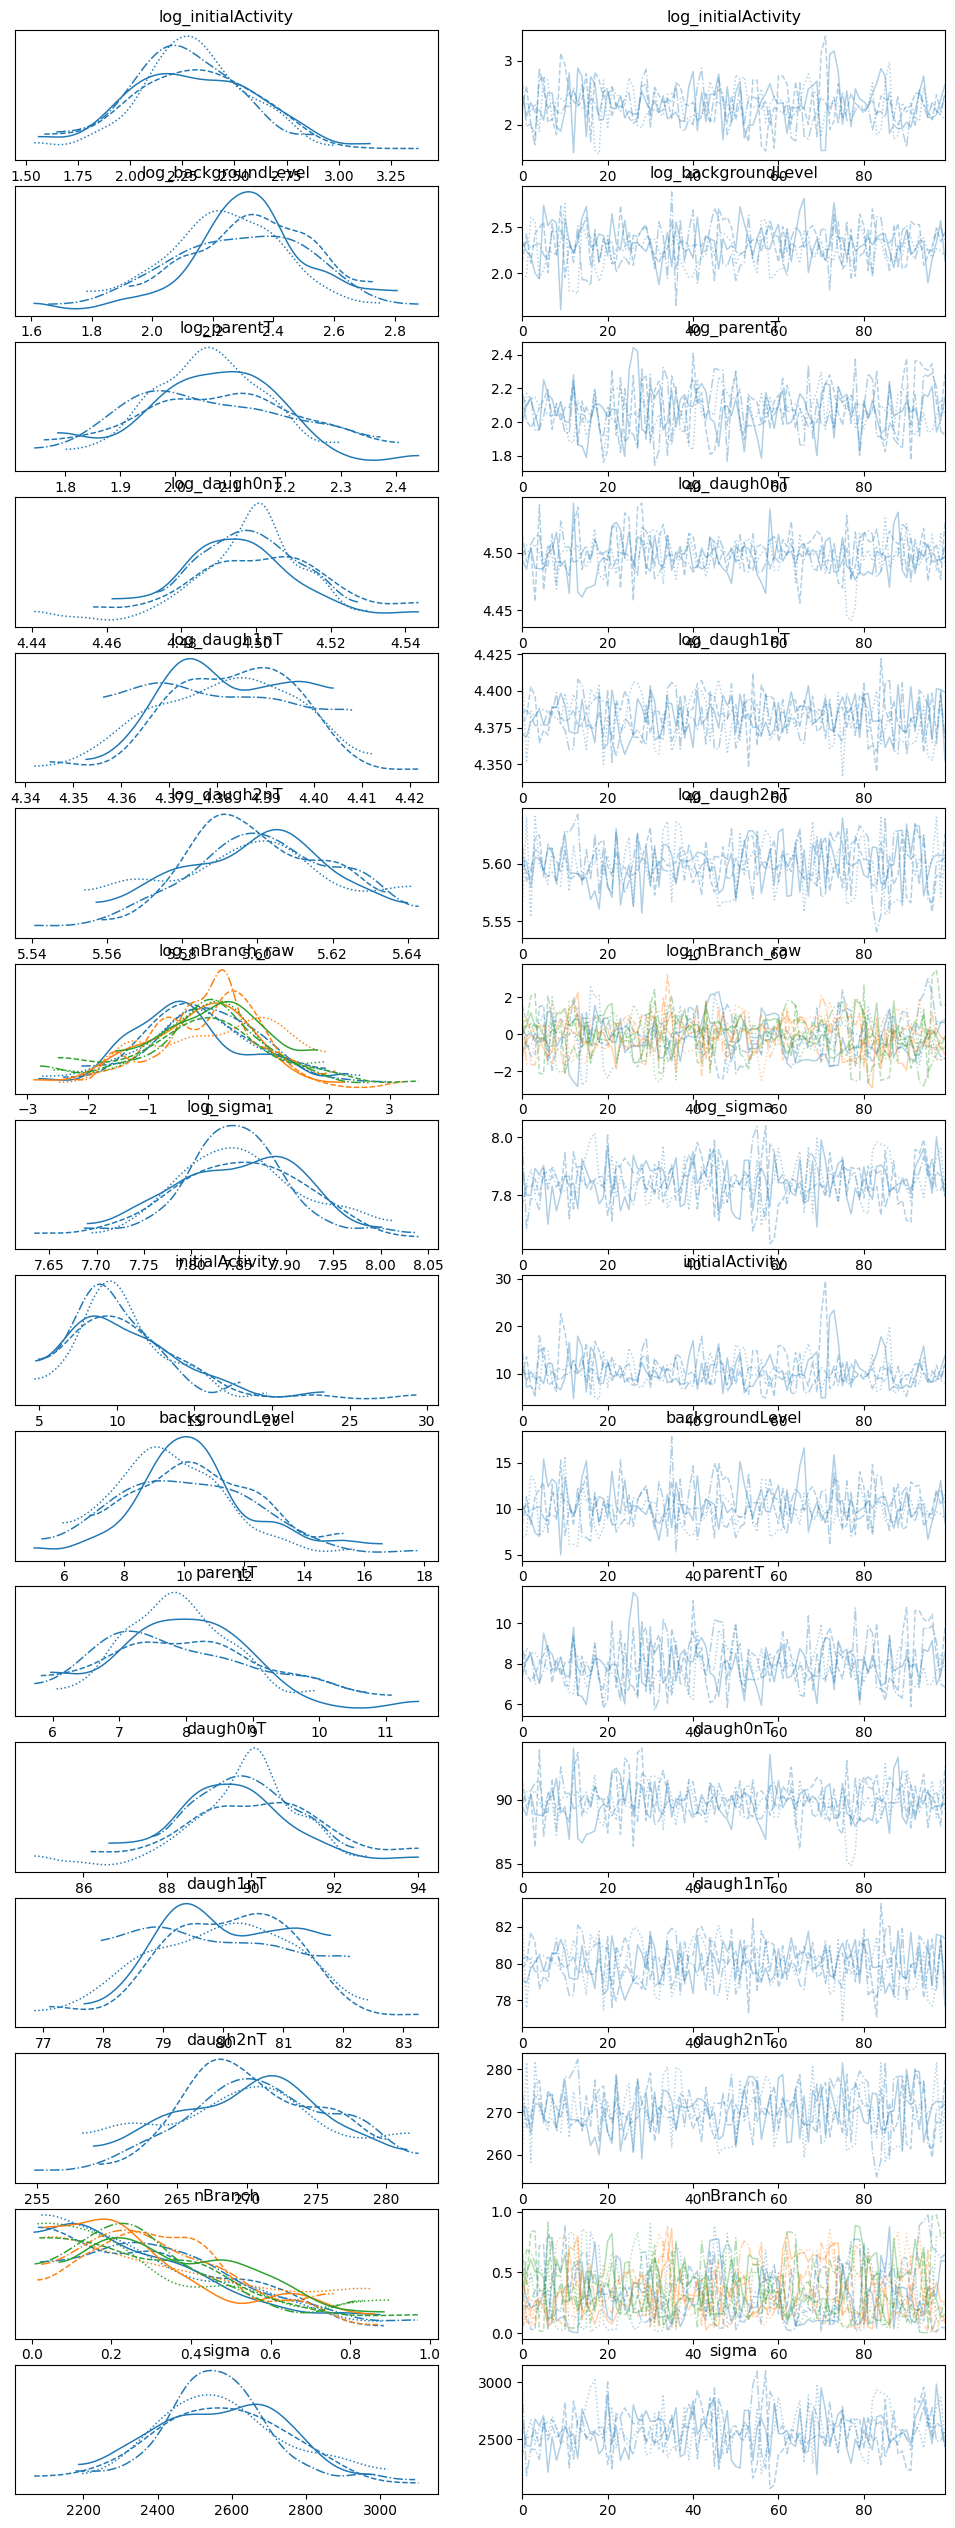

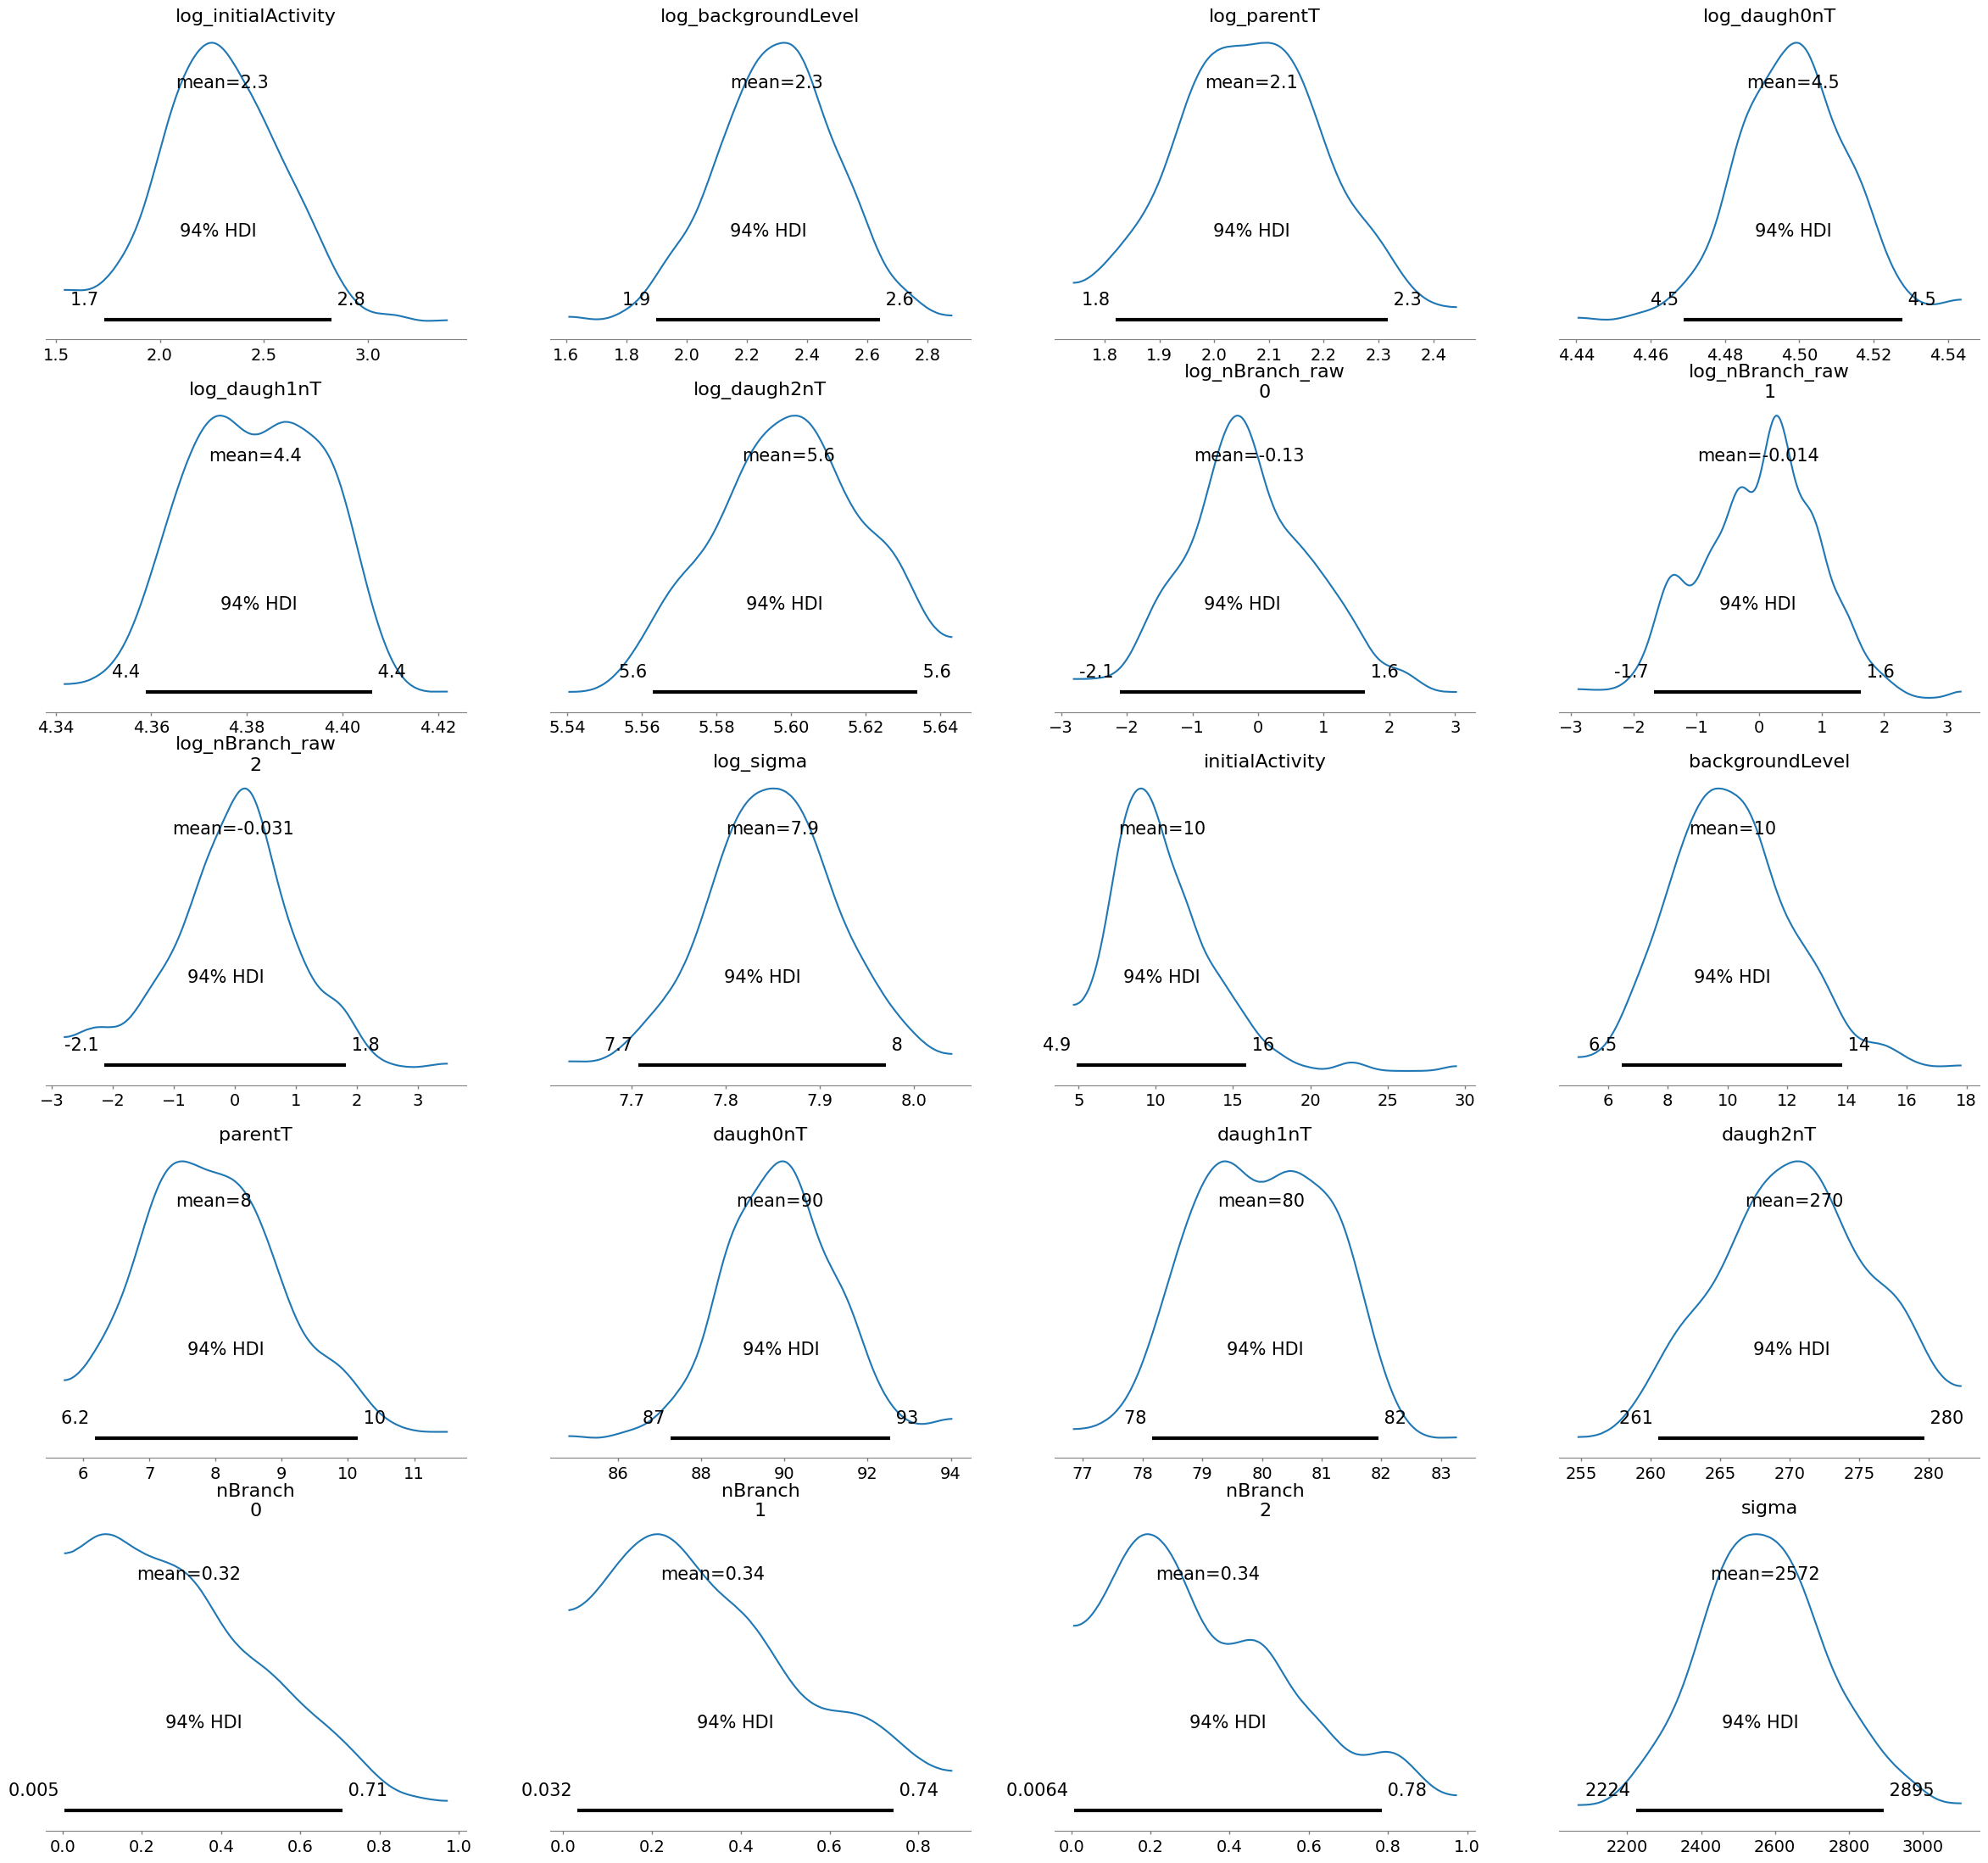

In [44]:
import pymc as pm
import aesara.tensor as at
import numpy as np

# --- 1. Define the Radioactive Decay Model (Bateman Equations for a simplified case) ---
# This function calculates the expected activity over time based on the decay parameters.
# It uses aesara.tensor for compatibility with PyMC's automatic differentiation.
def parent2nDaughterLinear(
    initialActivity, parentT, daugh0nT, daugh1nT, daugh2nT,
    nBranch0, nBranch1, nBranch2, backgroundLevel, decay_x
):
    """
    Calculates the expected activity over time for a parent decaying into
    multiple daughter products, considering branching ratios.

    This is a simplified model for demonstration. For a more rigorous
    radioactive decay chain, the full Bateman equations would be required.
    Here, we're modeling the activity as a sum of parent decay and
    contributions from daughters based on their half-lives and branching.

    Parameters:
    - initialActivity (at.TensorVariable): Initial activity of the parent isotope.
    - parentT (at.TensorVariable): Half-life (or mean lifetime) of the parent isotope.
    - daugh0nT, daugh1nT, daugh2nT (at.TensorVariable): Half-lives (or mean lifetimes)
      of the three daughter products.
    - nBranch0, nBranch1, nBranch2 (at.TensorVariable): Branching ratios for each daughter.
      These should sum to 1.
    - backgroundLevel (at.TensorVariable): Constant background activity.
    - decay_x (at.TensorVariable): Time points at which to calculate the activity.

    Returns:
    - at.TensorVariable: Expected activity at each time point.
    """

    # Decay constants (lambda = 1 / mean_lifetime, where mean_lifetime = T / ln(2) if T is half-life)
    # Assuming T here refers to the mean lifetime (tau), so lambda = 1/T
    lambda_p = 1.0 / parentT
    lambda_d0 = 1.0 / daugh0nT
    lambda_d1 = 1.0 / daugh1nT
    lambda_d2 = 1.0 / daugh2nT

    # Activity of the parent isotope at time t
    activity_parent = initialActivity * at.exp(-lambda_p * decay_x)

    # Simplified contribution from daughter activities.
    # IMPORTANT: This is a simplification. For true decay chains,
    # you would need to implement the Bateman equations, which account for
    # the production and decay of each daughter.
    # For example, for a single parent -> daughter decay:
    # A_daughter(t) = A_parent(0) * (lambda_daughter / (lambda_daughter - lambda_parent)) *
    #                 (exp(-lambda_parent * t) - exp(-lambda_daughter * t))
    # This example below is a linear combination, which might not accurately
    # represent the full kinetics of a decay chain with branching.
    # Adjust this part based on your specific physical model.

    # Here, we're conceptually adding a fraction of the initial activity decaying
    # at the daughter's rate, scaled by branching ratio. This is a common
    # simplification if the daughters decay much faster or if you're only
    # interested in the initial parent decay and a general "daughter product" signal.
    
    # NOTE: If your daughters are also radioactive and decay, their activity
    # will also contribute. This simplified model assumes their contribution
    # is directly proportional to the initial parent activity and their own decay rate.
    
    # This simplified model assumes that the total activity is a sum of the
    # parent's activity, and a fraction of the initial parent activity
    # decaying with the daughter's characteristic time, plus background.
    mu_val = (
        activity_parent +
        nBranch0 * initialActivity * at.exp(-lambda_d0 * decay_x) +
        nBranch1 * initialActivity * at.exp(-lambda_d1 * decay_x) +
        nBranch2 * initialActivity * at.exp(-lambda_d2 * decay_x) +
        backgroundLevel
    )

    return mu_val

# --- 2. Generate Synthetic Data for Demonstration ---
# In a real application, you would load your actual experimental data here.
# These values represent the "true" parameters that we will try to recover.
true_initial_activity = 5000.0
true_parent_T = 50.0  # Mean lifetime for parent
true_daugh0_T = 10.0  # Mean lifetime for daughter 0
true_daugh1_T = 20.0  # Mean lifetime for daughter 1
true_daugh2_T = 30.0  # Mean lifetime for daughter 2
true_nBranch = np.array([0.2, 0.3, 0.5]) # Branching ratios, must sum to 1
true_background = 50.0
true_sigma = 500.0 # Noise standard deviation

# Time points for observations
num_time_points = 100
time_max = 300
decay_x_data = np.linspace(0, time_max, num_time_points)

# Generate synthetic observed y data using the true parameters and the model
# Note: We use the numpy version of exp for data generation, as it's outside
# the PyMC model graph.
dummy_mu_data = (
    true_initial_activity * np.exp(-decay_x_data / true_parent_T) +
    true_nBranch[0] * true_initial_activity * np.exp(-decay_x_data / true_daugh0_T) +
    true_nBranch[1] * true_initial_activity * np.exp(-decay_x_data / true_daugh1_T) +
    true_nBranch[2] * true_initial_activity * np.exp(-decay_x_data / true_daugh2_T) +
    true_background
)
decay_y_data = np.random.normal(dummy_mu_data, true_sigma)

# --- 3. Define the PyMC Model ---
with pm.Model() as model:
    # Create Aesara shared variable for time points.
    # pm.Data MUST be defined inside the 'with pm.Model():' block.
    decay_x_shared = pm.Data('decay_x_shared', decay_x_data)

    # Priors for the parameters
    # Reparameterizing positive-constrained variables to use Normal on log-scale
    # This helps bypass 'TransformedVariable' NotImplementedError
    # For a target mean 'm' and std 's' for a log-normal variable Y=exp(X), X~N(mu_x, sigma_x^2):
    # sigma_x^2 = log(1 + (s/m)^2)
    # mu_x = log(m) - sigma_x^2 / 2

    # Initial Activity (target mean 10, std 3)
    log_initialActivity_mu = np.log(10.0) - np.log(1 + (3/10)**2)/2
    log_initialActivity_sigma = np.sqrt(np.log(1 + (3/10)**2))
    log_initialActivity = pm.Normal('log_initialActivity', mu=log_initialActivity_mu, sigma=log_initialActivity_sigma)
    initialActivity = pm.Deterministic('initialActivity', at.exp(log_initialActivity))

    # Background Level (target mean 10, std 2)
    log_backgroundLevel_mu = np.log(10.0) - np.log(1 + (2/10)**2)/2
    log_backgroundLevel_sigma = np.sqrt(np.log(1 + (2/10)**2))
    log_backgroundLevel = pm.Normal('log_backgroundLevel', mu=log_backgroundLevel_mu, sigma=log_backgroundLevel_sigma)
    backgroundLevel = pm.Deterministic('backgroundLevel', at.exp(log_backgroundLevel))

    # Parent Mean Lifetime (T) (target mean 8, std 1)
    log_parentT_mu = np.log(8.0) - np.log(1 + (1/8)**2)/2
    log_parentT_sigma = np.sqrt(np.log(1 + (1/8)**2))
    log_parentT = pm.Normal('log_parentT', mu=log_parentT_mu, sigma=log_parentT_sigma)
    parentT = pm.Deterministic('parentT', at.exp(log_parentT))

    # Daughter 0 Mean Lifetime (T) (target mean 90, std 1.5)
    log_daugh0nT_mu = np.log(90.0) - np.log(1 + (1.5/90)**2)/2
    log_daugh0nT_sigma = np.sqrt(np.log(1 + (1.5/90)**2))
    log_daugh0nT = pm.Normal('log_daugh0nT', mu=log_daugh0nT_mu, sigma=log_daugh0nT_sigma)
    daugh0nT = pm.Deterministic('daugh0nT', at.exp(log_daugh0nT))

    # Daughter 1 Mean Lifetime (T) (target mean 80, std 1.2)
    log_daugh1nT_mu = np.log(80.0) - np.log(1 + (1.2/80)**2)/2
    log_daugh1nT_sigma = np.sqrt(np.log(1 + (1.2/80)**2))
    log_daugh1nT = pm.Normal('log_daugh1nT', mu=log_daugh1nT_mu, sigma=log_daugh1nT_sigma)
    daugh1nT = pm.Deterministic('daugh1nT', at.exp(log_daugh1nT))

    # Daughter 2 Mean Lifetime (T) (target mean 270, std 5)
    log_daugh2nT_mu = np.log(270.0) - np.log(1 + (5/270)**2)/2
    log_daugh2nT_sigma = np.sqrt(np.log(1 + (5/270)**2))
    log_daugh2nT = pm.Normal('log_daugh2nT', mu=log_daugh2nT_mu, sigma=log_daugh2nT_sigma)
    daugh2nT = pm.Deterministic('daugh2nT', at.exp(log_daugh2nT))

    # Branching Ratios - Reparameterized using explicit Softmax
    # Define an unconstrained variable for the branching ratios
    log_nBranch_raw = pm.Normal('log_nBranch_raw', mu=0, sigma=1, shape=3) # shape=3 for 3 branches
    # Explicitly apply softmax: exp(x_i) / sum(exp(x_j))
    exp_log_nBranch_raw = at.exp(log_nBranch_raw)
    nBranch = pm.Deterministic('nBranch', exp_log_nBranch_raw / at.sum(exp_log_nBranch_raw))

    # Observation likelihood
    # Reparameterize sigma using a Normal on log-scale
    # Target mean for sigma is 1000. For HalfNormal(sigma=1000):
    # Mean = sigma * sqrt(2/pi) approx 1000 * 0.798 = 798
    # Std Dev = sigma * sqrt(1 - 2/pi) approx 1000 * 0.602 = 602
    # So for log-normal:
    # mu_log_sigma = log(798) - log(1 + (602/798)^2)/2
    # sigma_log_sigma = sqrt(log(1 + (602/798)^2))
    
    # Calculate target mean and std for the HalfNormal(sigma=1000)
    target_sigma_mean = 1000 * np.sqrt(2 / np.pi)
    target_sigma_std = 1000 * np.sqrt(1 - 2 / np.pi)

    log_sigma_mu = np.log(target_sigma_mean) - np.log(1 + (target_sigma_std / target_sigma_mean)**2) / 2
    log_sigma_sigma = np.sqrt(np.log(1 + (target_sigma_std / target_sigma_mean)**2))

    log_sigma = pm.Normal('log_sigma', mu=log_sigma_mu, sigma=log_sigma_sigma)
    sigma = pm.Deterministic('sigma', at.exp(log_sigma))

    # Model expectation (mu)
    # Calls the custom function to calculate the expected activity curve.
    # Ensures all inputs are Aesara/PyTensor variables.
    mu = parent2nDaughterLinear(
        initialActivity, parentT, daugh0nT, daugh1nT, daugh2nT,
        nBranch[0], nBranch[1], nBranch[2], backgroundLevel, decay_x_shared
    )

    # y_obs: The observed data, linked to the model's mean (mu) and noise (sigma).
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y_data)

    # --- 4. Sampling from the Posterior ---
    # Draws samples from the posterior distribution of the parameters.
    # tune: Number of tuning (warm-up) samples, which are discarded.
    # draw: Number of samples to keep after tuning.
    # target_accept: Target acceptance probability for the NUTS sampler.
    #                Higher values can reduce divergences but might slow sampling.
    # chains: Number of independent sampling chains to run.
    print("Starting NUTS sampling...")
    trace = pm.sample(draws=100, tune=100, target_accept=0.995, chains=4)
    print("Sampling complete.")

    # --- 5. Analyze the Results (Optional) ---
    # You can uncomment the following lines to print a summary or plot the trace.
    print("\nTrace Summary:")
    print(pm.summary(trace))

    # To plot the trace and posterior distributions:
    import arviz as az
    az.plot_trace(trace)
    az.plot_posterior(trace)
    import matplotlib.pyplot as plt
    plt.show() # Make sure to show plots if running in a script


In [58]:
# Load and preprocess data
df = pd.read_csv('hist_33Na.csv')
df = df[(df['xVal'] >= -100) & (df['xVal'] <= 40)]

# Rebin by factor of 2
df['bin'] = df['xVal'] // 2 * 2
df_rebinned = df.groupby('bin').agg({'yVal': 'sum'}).reset_index().rename(columns={'bin': 'x', 'yVal': 'y'})
x_rebinned = df_rebinned['x'].values
y_rebinned = df_rebinned['y'].values

In [59]:
# Background estimation from x < 0
pre_y = y_rebinned[x_rebinned < 0]
bkg_est = np.mean(pre_y)

# Decay region
decay_x = x_rebinned[x_rebinned >= 0]
decay_y = y_rebinned[x_rebinned >= 0]
decay_x_shared = at.as_tensor_variable(decay_x)

In [ ]:
with pm.Model() as model:
    # Priors — explicitly disable transforms to avoid AEPPL crash
    initialActivity = pm.Gamma('initialActivity', alpha=(10**2)/(3**2), beta=10/(3**2), initval=36000, transform=None)
    backgroundLevel = pm.Gamma('backgroundLevel', alpha=(10**2)/(2**2), beta=10/(2**2), initval=8000, transform=None)

    parentT   = pm.Gamma('parentT', alpha=(8**2)/(1**2), beta=8/(1**2), initval=8.2, transform=None)
    daugh0nT  = pm.Gamma('daugh0nT', alpha=(90**2)/(1.5**2), beta=90/(1.5**2), initval=90.2, transform=None)
    daugh1nT  = pm.Gamma('daugh1nT', alpha=(80**2)/(1.2**2), beta=80/(1.2**2), initval=80.4, transform=None)
    daugh2nT  = pm.Gamma('daugh2nT', alpha=(270**2)/(5**2), beta=270/(5**2), initval=270, transform=None)

    # Branching ratios — Dirichlet does not apply a transform (OK)
    nBranch = pm.Dirichlet('nBranch', a=[2, 2, 2], initval=[0.3, 0.4, 0.3], transform=None)

    # Expected signal
    mu = parent2nDaughterLinear(
        initialActivity, parentT, daugh0nT, daugh1nT, daugh2nT,
        nBranch[0], nBranch[1], nBranch[2], backgroundLevel, decay_x_shared
    )

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1000, initval=500, transform=None)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)

    # Sample
    trace = pm.sample(
        100,
        tune=100,
        target_accept=0.995,
        chains=1,
        init="adapt_diag"
    )
    import arviz as az
    az.plot_trace(trace)
    az.plot_posterior(trace)
    import matplotlib.pyplot as plt
    plt.show() # Make sure to show plots if running in a script

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initialActivity, backgroundLevel, parentT, daugh0nT, daugh1nT, daugh2nT, nBranch, sigma]


/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


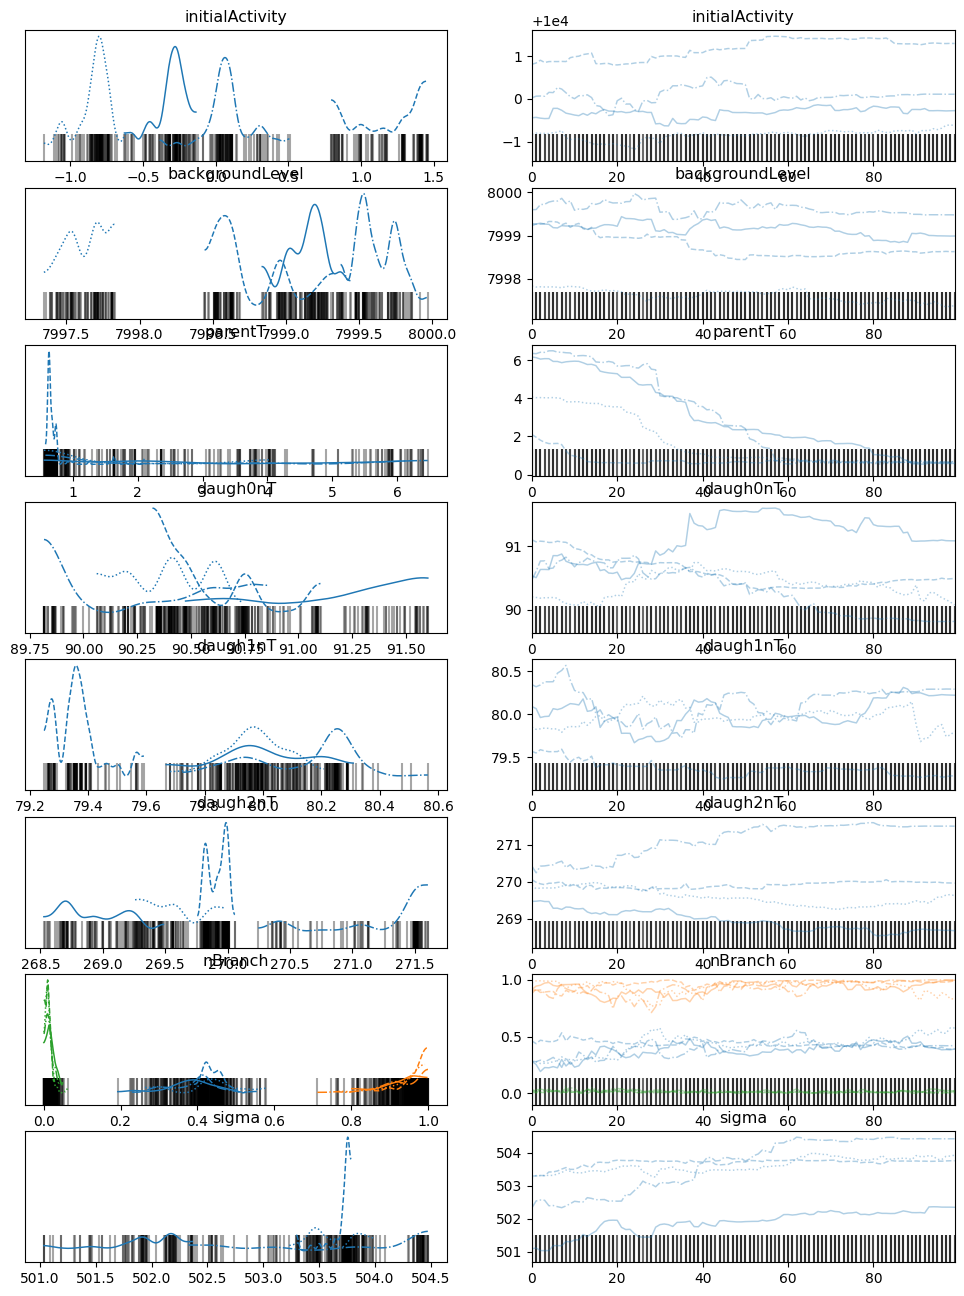

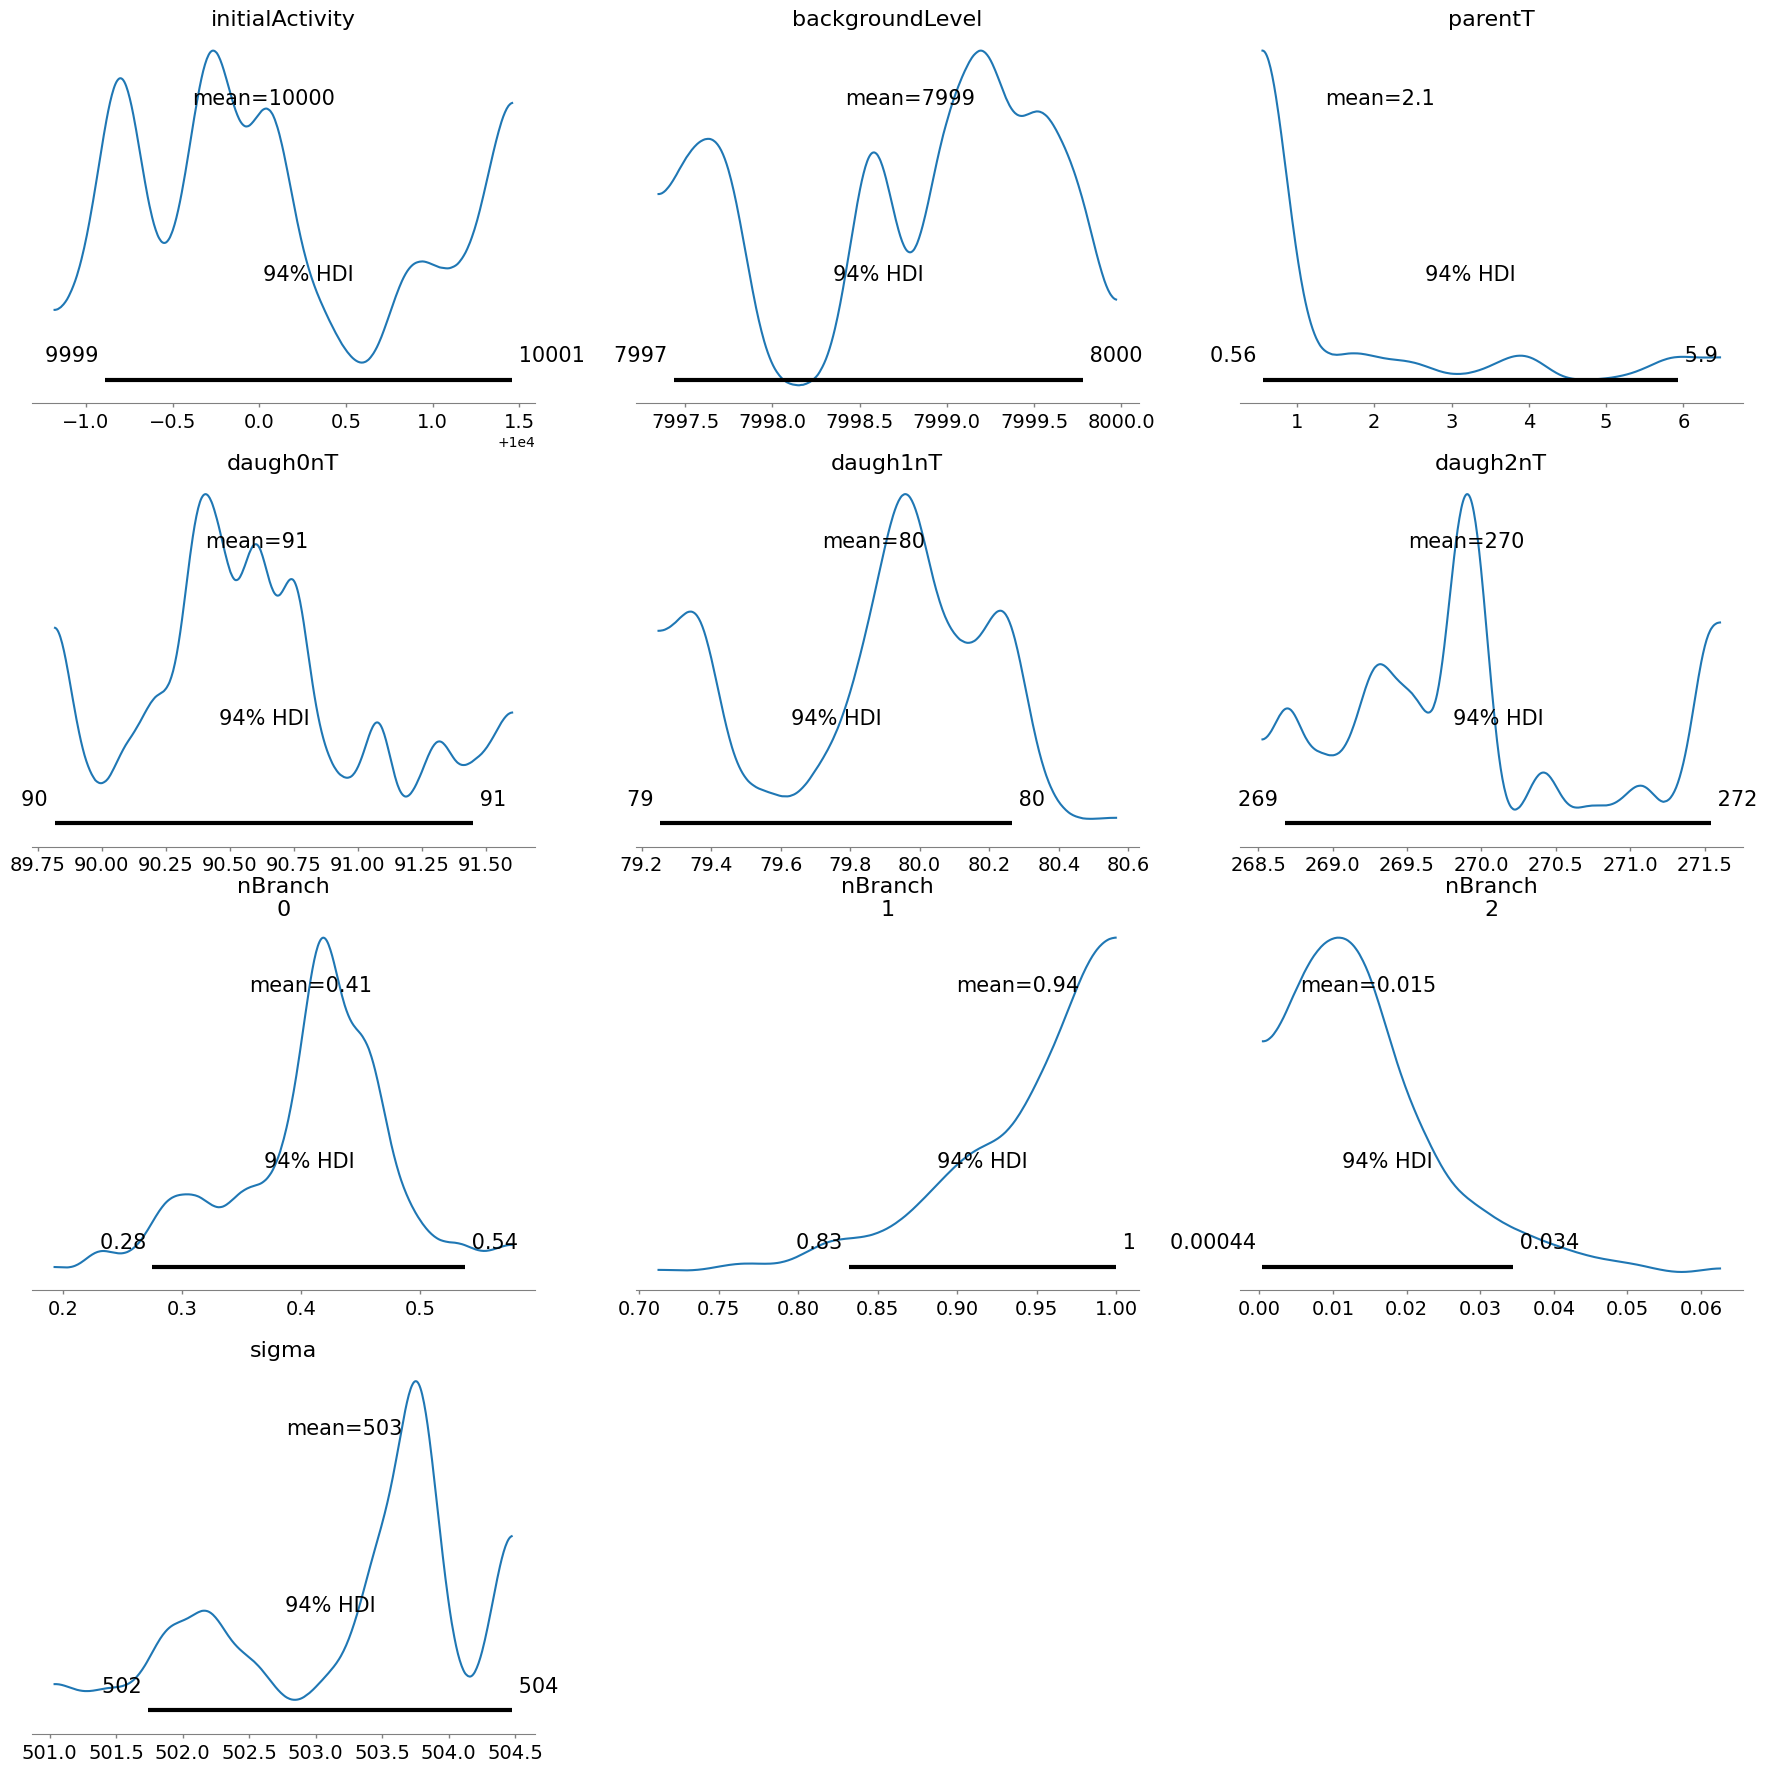

In [57]:
import arviz as az
az.plot_trace(trace)
az.plot_posterior(trace)
import matplotlib.pyplot as plt
plt.show() # Make sure to show plots if running in a script

In [ ]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
import multiprocessing

In [3]:
# Load and preprocess data
df = pd.read_csv('hist_33Na.csv')
df = df[(df['xVal'] >= -100) & (df['xVal'] <= 40)]

# Rebin by factor of 2
df['bin'] = df['xVal'] // 2 * 2
df_rebinned = df.groupby('bin').agg({'yVal': 'sum'}).reset_index().rename(columns={'bin': 'x', 'yVal': 'y'})
x_rebinned = df_rebinned['x'].values
y_rebinned = df_rebinned['y'].values

In [25]:
import aesara.tensor as at

def parent(t_parent, a0, x):
    return a0 * at.exp(- (at.log(2) / t_parent) * x)

def daughter(t_daugh, t_parent, a0, br, x):
    lam_d = at.log(2) / t_daugh
    lam_p = at.log(2) / t_parent
    return a0 * br * (lam_p / (lam_d - lam_p)) * (at.exp(-lam_p * x) - at.exp(-lam_d * x))

def parent2nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, br0, br1, br2, bkg, x):
    return (
        parent(t_parent, a0, x) +
        daughter(t_daugh0n, t_parent, a0, br0, x) +
        daughter(t_daugh1n, t_parent, a0, br1, x) +
        daughter(t_daugh2n, t_parent, a0, br2, x) +
        bkg
    )


In [29]:
# Background estimation from x < 0
pre_y = y_rebinned[x_rebinned < 0]
bkg_est = np.mean(pre_y)

# Decay region
decay_x = x_rebinned[x_rebinned >= 0]
decay_y = y_rebinned[x_rebinned >= 0]
decay_x_shared = at.as_tensor_variable(decay_x)


In [30]:
with pm.Model() as model:
    # Priors
    initialActivity = pm.Gamma('initialActivity', alpha=10**2 / 3**2, beta=10 / 3**2)
    backgroundLevel = pm.Gamma('backgroundLevel', alpha=10**2 / 2**2, beta=10 / 2**2)

    parentT   = pm.Gamma('parentT', alpha=8**2 / 1**2, beta=8 / 1**2)
    daugh0nT  = pm.Gamma('daugh0nT', alpha=90**2 / 1.5**2, beta=90 / 1.5**2)
    daugh1nT  = pm.Gamma('daugh1nT', alpha=80**2 / 1.2**2, beta=80 / 1.2**2)
    daugh2nT  = pm.Gamma('daugh2nT', alpha=270**2 / 5**2, beta=270 / 5**2)

    # Branching Ratios
    nBranch = pm.Dirichlet('nBranch', a=[2, 2, 2], transform=None)  # Only disable here

    # Model expectation (ensure this uses aesara.tensor not numpy)
    mu = parent2nDaughterLinear(
        initialActivity, parentT, daugh0nT, daugh1nT, daugh2nT,
        nBranch[0], nBranch[1], nBranch[2], backgroundLevel, decay_x_shared
    )

    # Observation likelihood
    sigma = pm.HalfNormal('sigma', sigma=1000)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.995, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


NotImplementedError: These `Op`s should be removed from graphs used for computation.
Apply node that caused the error: TransformedVariable(Elemwise{exp,no_inplace}.0, initialActivity_log__)
Toposort index: 1
Inputs types: [TensorType(float64, ()), TensorType(float64, ())]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [array(22.57098116), array(3.11666506)]
Inputs type_num: [12, 12]
Outputs clients: [[Elemwise{log,no_inplace}(initialActivity_log___log), Elemwise{eq,no_inplace}(initialActivity_log___log, TensorConstant{0}), Elemwise{ge,no_inplace}(initialActivity_log___log, TensorConstant{0.0}), InplaceDimShuffle{x}(initialActivity_log___log), Elemwise{mul,no_inplace}(TensorConstant{1.1111111111111112}, initialActivity_log___log)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aeppl/transforms.py", line 213, in apply
    return self.default_transform_opt.optimize(fgraph)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/graph/opt.py", line 102, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/graph/opt.py", line 1971, in apply
    nb += self.process_node(fgraph, node)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aeppl/transforms.py", line 159, in transform_values
    transform.backward(value_var, *trans_node.inputs), value_var
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/graph/op.py", line 297, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/projects/e21062/tg/venv/lib/python3.7/site-packages/aeppl/transforms.py", line 53, in make_node
    return Apply(self, [tran_value, value], [tran_value.type()])

Debug print of the apply node: 
TransformedVariable [id A] <TensorType(float64, ())> 'initialActivity_log___log'

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import aesara

# 🛠 Use Python linker instead of C to avoid memory errors
aesara.config.linker = "py"
aesara.config.optimizer = "fast_compile"
aesara.config.exception_verbosity = "high"

# 🧠 Reduce the number of samples for posterior predictive if memory is tight
trace_subset = trace.sel(draw=slice(0, 100))  # Adjust slice if needed

# 🔄 Posterior predictive sampling
ppc = pm.sample_posterior_predictive(trace_subset, model=model, var_names=["y_obs"], progressbar=True)
y_samples = ppc.posterior_predictive["y_obs"].stack(sample=("chain", "draw")).values

# 📊 Summary statistics
y_mean = y_samples.mean(axis=1)
y_std = y_samples.std(axis=1)
y_hdi_lower, y_hdi_upper = np.percentile(y_samples, [2.5, 97.5], axis=1)

# 📉 Normalized residuals
residuals = (decay_y - y_mean) / y_std

# -----------------------------
# 📈 Figure 1: Fit with Uncertainty
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(decay_x, decay_y, 'ko', label='Observed Data', markersize=4)
plt.plot(decay_x, y_mean, 'b-', label='Mean Prediction')
plt.fill_between(decay_x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Posterior Predictive Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 📉 Figure 2: Normalized Residuals
# -----------------------------
plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.plot(decay_x, residuals, 'ro', label='Normalized Residuals')
plt.xlabel('Time (ms)')
plt.ylabel('(Observed - Predicted) / σ')
plt.title('Normalized Residuals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'log_initialActivity'

In [ ]:
# Normalized residuals
std = samples.std(axis=1)
residuals = (decay_y - mean_pred) / std

plt.figure(figsize=(8,4))
plt.axhline(0, color='black', linestyle='--')
plt.plot(decay_x, residuals, 'ro', label='Normalized Residuals')
plt.xlabel('Time (ms)')
plt.ylabel('Residual')
plt.title('Normalized Residuals')
plt.grid(True)
plt.legend()
plt.show()